In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import numpy as np 

# <strong>Summary Statistic and Plots<strong>
- Creating profit margin column by subtracting fixed cost, variable cost, and rental cost from gross revenue and dividing that number with gross revenue
- Visualizing the mean and median distribution of profit margin. They both look normally distributed with a trailing left tail.

The average mean profit margin is 24.33% and the average median profit margin is 24.71%



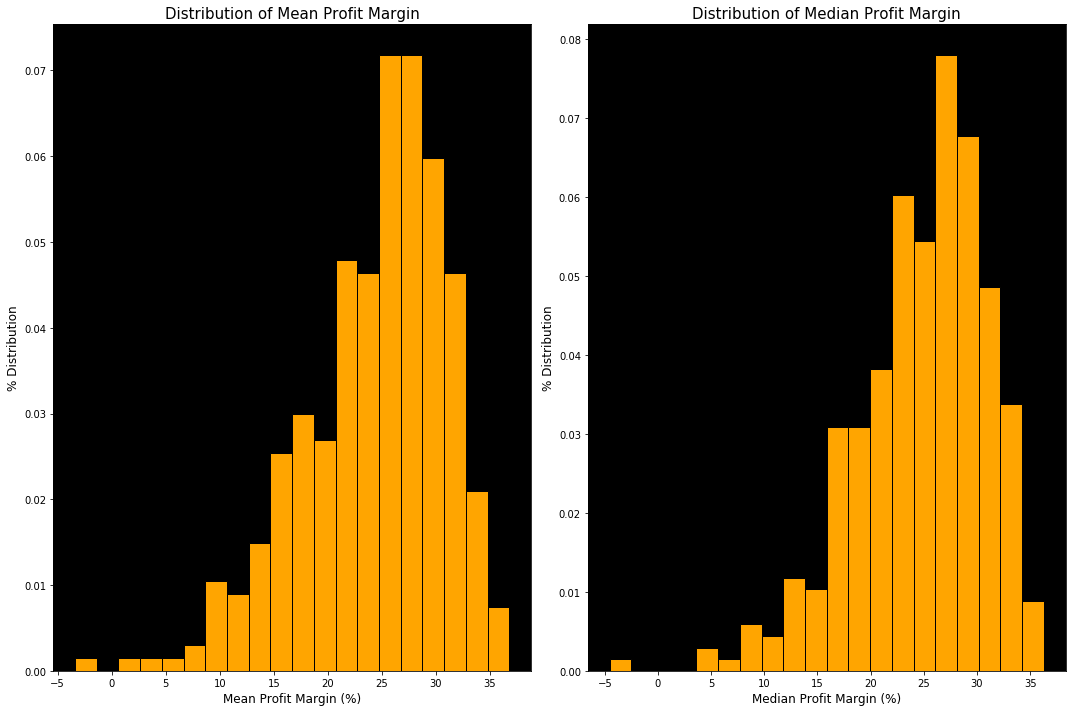

In [32]:
df = pd.read_csv('summer_internship_takehome.csv')

#distribution histogram
def histogram(df, metric, index=False):
    n,bins,patches = ax[index].hist(df, 20, density=1, color='orange', edgecolor='black')
    ax[index].set_facecolor('black')
    ax[index].set_title(f'Distribution of {metric} Profit Margin', fontsize=15)
    ax[index].set_xlabel(f'{metric} Profit Margin (%)', fontsize=12)
    ax[index].set_ylabel('% Distribution', fontsize=12)

    
#line plot 
def line_plot(df, metric='Monthly', index=False):
    ax[index].plot(list(df.columns), [sum(df[column]) for column in df.columns], color="orange", linewidth=2)
    ax[index].set_facecolor('black')
    ax[index].grid(color='grey', axis='y', linestyle='dotted')
    ax[index].set_title(f"Aggregate {metric} Revenue", fontsize=15)
    ax[index].set_xlabel(f'{metric} Timeframe')
    ax[index].set_ylabel(f'Sum {metric} Revenue (Billions)', fontsize=12)
    
#calculating profit margin ((gross revenue - (fixed + variable + rent))/gross revenue) * 100
df['profit_margin'] = (df['Gross revenue'] - (df['Fixed cost'] + df['Variable cost'] + df['Rental cost']))/(df['Gross revenue']) * 100

#getting aggregate median and mean profit margins
df_mean = df.groupby('Location number').mean()['profit_margin']
df_median = df.groupby('Location number').median()['profit_margin']

#distribution of mean and median profit
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
histogram(df_mean, 'Mean', 0)
histogram(df_median, 'Median', 1)
fig.tight_layout()
print(f"The average mean profit margin is {round(df_mean.mean(),2)}% and the average median profit margin is {round(df_median.mean(),2)}%\n")

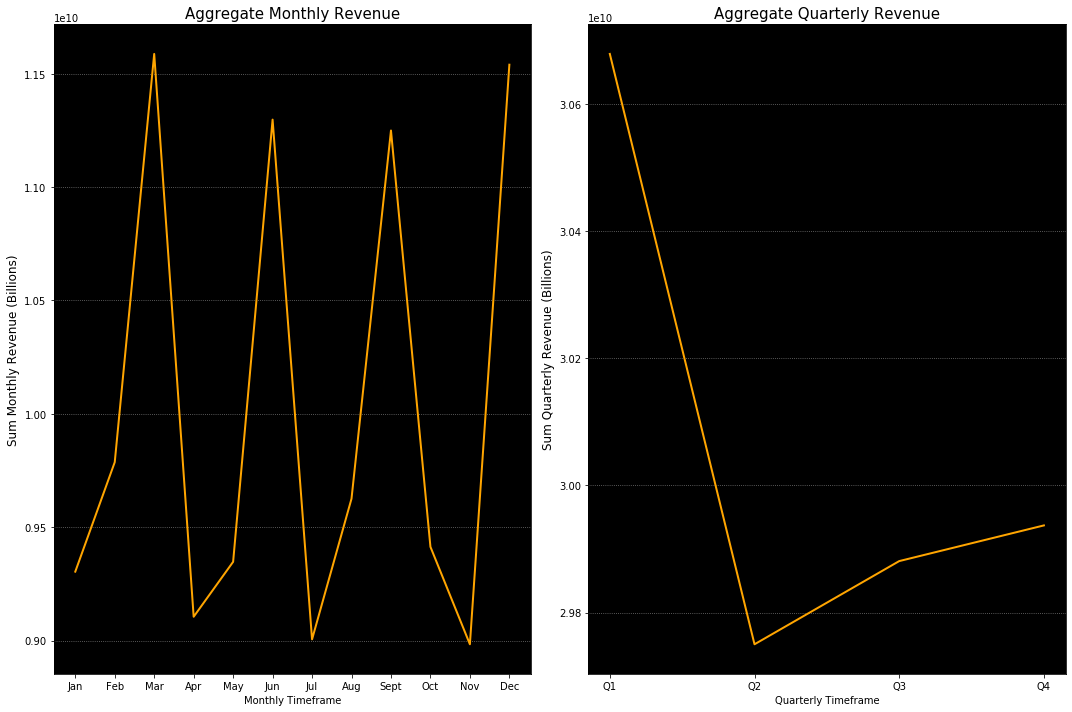

In [33]:
#calculating monthly & quarterly revenue by transposing dataframe and aggregating into months/quarterly respectively
df_monthly = pd.pivot_table(df, index='Location number', columns='Month', values='Gross revenue')
df_monthly.columns = 'Jan Feb Mar Apr May Jun Jul Aug Sept Oct Nov Dec'.split(' ')

#quarterly revenue 
dic = {}
count = 1
for index in range(0, len(df_monthly.columns), 3):
    quarter = list(df_monthly.columns)[index:index+3]
    revenue_list = [sum(df_monthly[month]) for month in quarter]
    dic[f"Q{count}"] = sum(revenue_list)
    count += 1
df_quarterly = pd.DataFrame(dic, index=[0])

#graphing aggregate monthly and quarterly revenue
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
line_plot(df_monthly, 'Monthly', 0)
line_plot(df_quarterly, 'Quarterly', 1)
fig.tight_layout()

Wrangling dataframes to display data in a montly & quarterly format. After visualizing the data, it is evident that there is a cyclical nature to the aggregate revenuec

# <strong>Cleaning the Data</strong>
- Normalizing the "apples to orange" comparison between owened and leased locations 
- Adjusted the rent by applying the mean rent of the owned location's state to its "Rental cost" column
- Resulted in very minimal changes in mean & median profit. Such changes are negligable and are not reflected in both the graph and second decimal calculation.

In [5]:
#adjusting rent by taking average rent of each state and adding that to owned locations
mean_monthly_rent = df[df['Owned'] == False].groupby('State').mean()['Rental cost'].to_dict()
adjusted_df = df.copy()
adjusted_df['Rental cost'] = adjusted_df.apply(lambda row: mean_monthly_rent[row.State] if row.Owned else row['Rental cost'], axis=1)

#looking at adjusted median and mean profit margin
adjusted_mean = adjusted_df.groupby('Location number').mean()['profit_margin']
adjusted_median = adjusted_df.groupby('Location number').median()['profit_margin']
print(f"The adjusted mean profit margin is {round(adjusted_mean.mean(), 2)}% and the adjusted median profit margin is {round(adjusted_median.mean(), 2)}%")

The adjusted mean profit margin is 24.33% and the adjusted median profit margin is 24.71%


# <strong>Quantify Drivers of Success</strong>
- Using the covariance matrix to look at which variables to "investigate" further.
- Gross revenue, fixed costs, variable costs, and rental costs have strong multicollinear traits, therefore we are going to exclude them from our intital analysis
- From the covariance matrix, it is evident that month of business have little effect on the data set. However, it seems like "Number of products" has a strong correlation with profit margin.

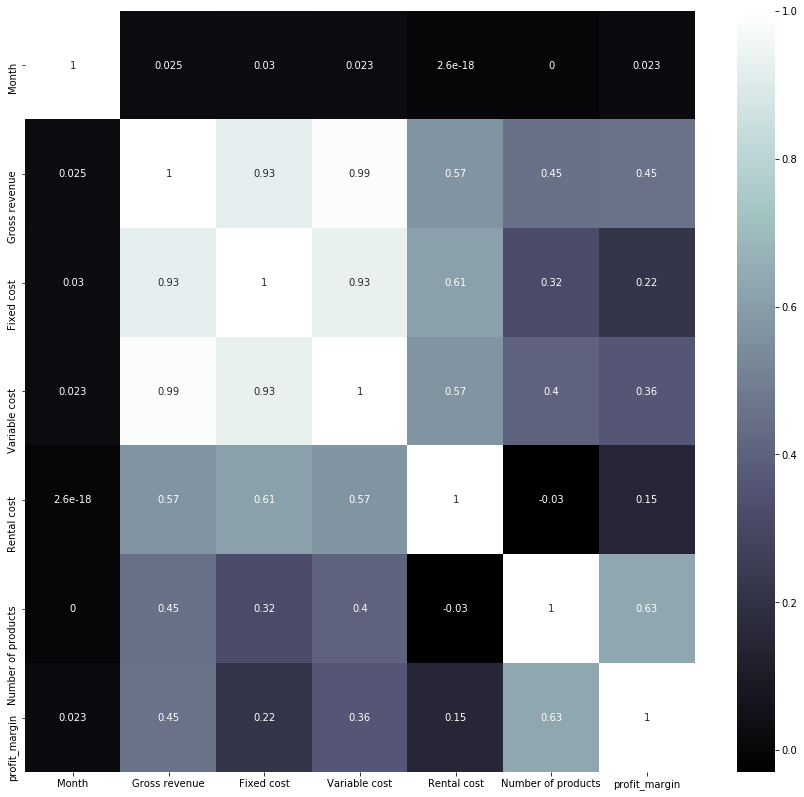

In [6]:
#looking at correlation between quantitative variables (dropped classification variables)
plt.figure(figsize=(15,14))
sns.heatmap(adjusted_df[list(adjusted_df.drop(columns=['Owned', 'State', 'Location number']).columns)].corr(), annot=True, cmap='bone')

## Analysis of Number of Products
- Due to the high Pearson coefficient demonstrated in the covariance matrix, the goal of the "Product analysis" is to get rid of multicollinearity and determine feature importance with the goal of extrapolating profit margin from number of products

The Pearson coefficient of 0.8526656528776074 suggests a strong, positive linear correlation between profit margin and number of products. 



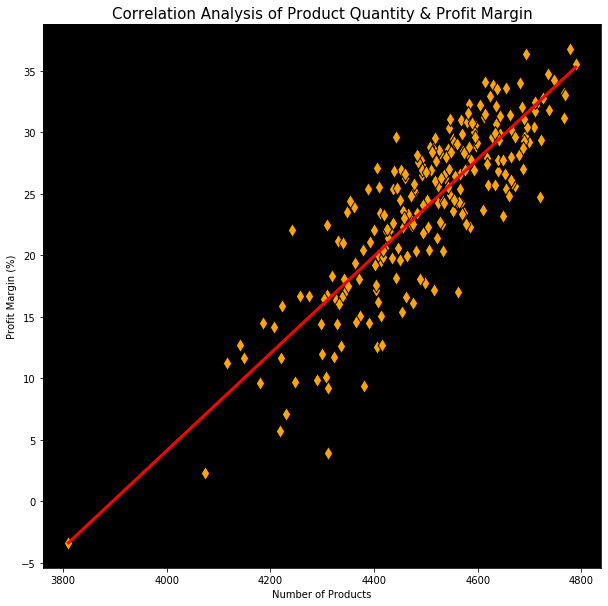

In [7]:
from scipy.stats import pearsonr

#finding the mean profit margin for each unique number of products value
product_values = df['Number of products'].unique()
dic = {}
for num in product_values:
    dic[num] = df[df['Number of products'] == num]['profit_margin'].mean()
product_df = pd.DataFrame(dic, index=[0]).T

#graphing the data above along with conducting further correlation analysis
fig, ax = plt.subplots(figsize=(10,10))
x, y = product_df.index, product_df[0]
ax.scatter(product_df.index, product_df[0], edgecolor='black', color='orange', s=100, marker='d')
ax.set_facecolor('black')
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red', linewidth=3, label='Best Fit')
ax.set_title('Correlation Analysis of Product Quantity & Profit Margin', fontsize=15)
ax.set_xlabel('Number of Products')
ax.set_ylabel('Profit Margin (%)')
pearson_coefficient = pearsonr(x, y)
print(f"The Pearson coefficient of {pearson_coefficient[0]} suggests a strong, positive linear correlation between profit margin and number of products. \n")

The graph above visualizes the mean profit margin of every unique "Number of products" within the data set. The Pearson coefficient of 0.853 suggests a strong, positive linear correlation between profit margin and number of products and gives us the "go-ahead" to conduct more in-depth analysis.

### <strong>Creating Predictive Models</strong>
- The first step of creating such models is separating the data set into separation train & validation categories. Within my analysis, I used 90% of the data set to train the regression models and 10% to validate the results.
- The initial approach was to normalize the data by centering the the column values at zero and standardizing variance at one. The values of the different columns in our data set were vastly different and such a method was necessary to create accurate models. However, as we later confirmed that data points like "Month" and "Location" had minimal effects on our model, we dropped those columns and inversely transformed our data set back to its original form. Such action actually decreased the MSE of our models
- For the predictive models, I used ElasticNet, Lasso, Ridge, and Random Forest regression. I chose these models because they deduce multicollinearity within the data set and penalize such variables. To further increase the accuracy of my models, I implemnted a grid search to conduct hyperparameter optimzation. 

In [8]:
#cleaning data to train regression models
from sklearn.model_selection import train_test_split
model_df = adjusted_df.copy()

#turning State column (categorical variable) into numerical representation 
state_list = pd.get_dummies(model_df['State'])
model_df = pd.concat([model_df.drop(['State'], 1), state_list], 1)
state_categories = state_list.columns

#dropping collinear & noisy data
x_data = model_df.drop(columns = ['Location number', 'Owned', 'profit_margin', 'Gross revenue', 'Fixed cost', 'Variable cost', 'Rental cost', 'Month'] + list(state_categories))
y_data = model_df['profit_margin']

#separating train and validation data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, train_size = 0.9)

#converting training and validation data into numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

#normalizing data by centering variable at zero and standardizing variance at 1

#defining parameters for hyperparameter optimzation
params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}

#ElasticNet Regression
elastic = ElasticNet()
elastic = GridSearchCV(estimator=elastic, param_grid=params)
elastic = elastic.fit(x_train, y_train)

#Lasso Regression 
lasso = Lasso()
lasso = GridSearchCV(estimator=lasso, param_grid=params)
lasso = lasso.fit(x_train, y_train)

#Ridge Regression 
ridge = Ridge()
ridge = GridSearchCV(estimator=ridge, param_grid=params)
ridge = ridge.fit(x_train, y_train)

#Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state=42)
rf = rf.fit(x_train, y_train)

C:\Users\Philip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Philip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Philip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [10]:
#verifying model accuracy using mean squared error
from sklearn.metrics import mean_squared_error
def mse(model, model_name):
    return f"The MSE of {model_name} model is {mean_squared_error(model.predict(x_val), y_val)}\n"

model_dic = {key:value for key,value in zip(['ElasticNet','Lasso', 'Ridge', 'Random Forest'], [elastic, lasso, ridge, rf])}

for key in model_dic: 
    print(mse(model_dic[key], key))

The MSE of ElasticNet model is 37.35668338844412

The MSE of Lasso model is 37.35660802483236

The MSE of Ridge model is 37.35676497587563

The MSE of Random Forest model is 32.447899205416725



<strong>The mean squared error of the models are pretty good considering the size of the data set.<strong> 

In [11]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from IPython.core.display import display, HTML

#extracting weights from models 
for key in model_dic: 
    perm = PermutationImportance(model_dic[key]).fit(x_train, y_train)
    weights = eli5.show_weights(perm, feature_names=x_data.columns.tolist())
    print(f'The weights of {key} model')
    print("-" * 35)
    display(weights)
    print()

Using TensorFlow backend.


The weights of ElasticNet model
-----------------------------------


Weight,Feature
0.7991 ± 0.0366,Number of products



The weights of Lasso model
-----------------------------------


Weight,Feature
0.7960 ± 0.0416,Number of products



The weights of Ridge model
-----------------------------------


Weight,Feature
0.7894 ± 0.0700,Number of products



The weights of Random Forest model
-----------------------------------


Weight,Feature
1.0986 ± 0.0422,Number of products


<strong>The weights of the model show heavy emphasis on Number of products. Previous models with other data points showed similar weights. Eliminating those data points actually reduced noise and increased the accuracy of the models.</strong>

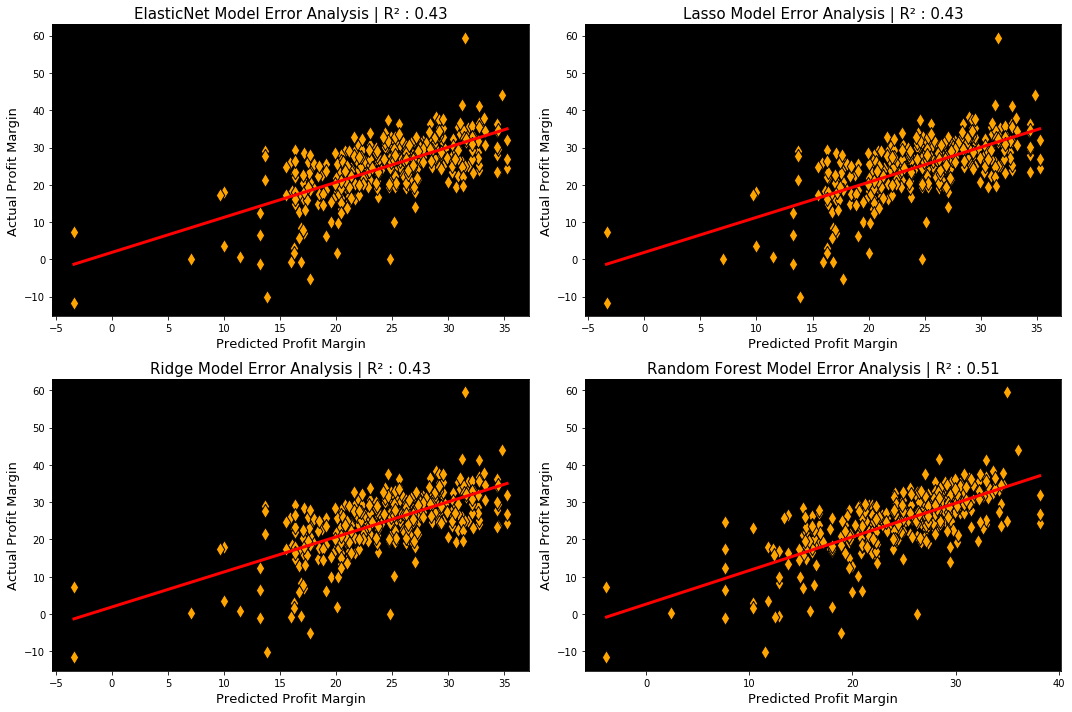

In [12]:
#displaying model residuals 
def show_scatter(model, name, row, col):
    x = [float(i) for i in list(model.predict(x_val))]
    y = [float(i) for i in list(y_val)]
    ax[row][col].scatter(x, y, edgecolor='black', color='orange', marker='d', s=100)
    ax[row][col].set_facecolor('black')
    ax[row][col].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red', linewidth=3, label='Best Fit')
    ax[row][col].set_title(f'{name} Model Error Analysis | R² : {round(pearsonr(x, y)[0] ** 2,2)}', fontsize=15)
    ax[row][col].set_ylabel('Actual Profit Margin', fontsize=13)
    ax[row][col].set_xlabel('Predicted Profit Margin', fontsize=13)
    
model_list = [[key for key in list(model_dic.keys())[:2]]]
model_list.append([key for key in list(model_dic.keys())[2:]])
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
for row in range(len(model_list)):
    for col in range(len(model_list[row])):
        key = model_list[row][col]
        show_scatter(model_dic[key], key, row, col)
fig.tight_layout()

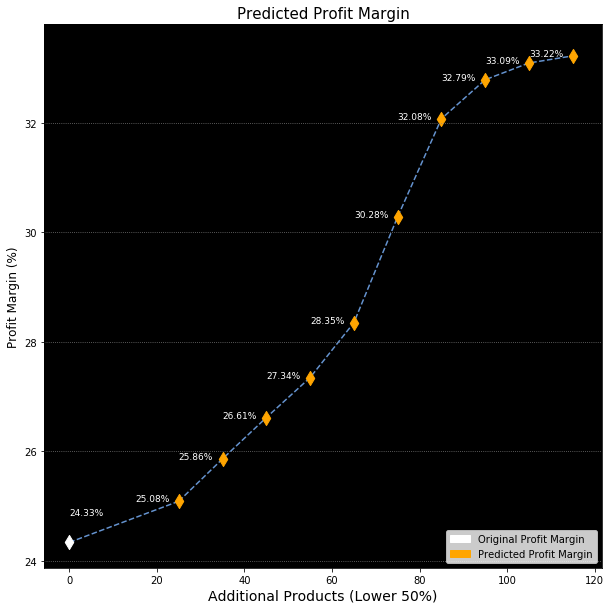

In [35]:
#generating predictive model graph
test_df = df.copy()
test_df = test_df.groupby('Location number').mean().sort_values(by='Number of products')
value_set = set(test_df.iloc[:167].index)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(0, df['profit_margin'].mean(), color='white', marker='d', s=100)
ax.text(0, df['profit_margin'].mean() + 0.5, f"{round(df['profit_margin'].mean(),2)}%", fontsize=9, color='white')
base = 25
predicted_list = []
base_list = []

for _ in range(10):
    test_df['Number of products'] = test_df.apply(lambda row: row['Number of products'] + base if row.name in value_set else row['Number of products'], axis=1)
    predicted = rf.predict(np.array(test_df['Number of products']).reshape(-1,1)).mean()
    predicted_list.append(predicted)
    base_list.append(base)
    ax.scatter(base, predicted, color='orange', s=100, marker='d')
    ax.text(base-10, predicted, f"{round(predicted,2)}%", fontsize=9, color='white')
    ax.set_facecolor('black')
    ax.grid(axis='y', color='grey', linestyle='dotted')
    ax.set_xlabel('Additional Products (Lower 50%)', fontsize=14)
    ax.set_ylabel('Profit Margin (%)', fontsize=12)
    ax.set_title('Predicted Profit Margin', fontsize=15)
    white_patch = mpatches.Patch(color='white', label='Original Profit Margin')
    orange_patch = mpatches.Patch(color='orange', label='Predicted Profit Margin')
    ax.legend(handles=[white_patch, orange_patch], loc='lower right')
    base += 10
ax.plot(base_list, predicted_list, color='#6593cf', zorder=-1, linestyle='dashed')
ax.plot([0, base_list[0]], [df['profit_margin'].mean(), predicted_list[0]], color='#6593cf', zorder=-1, linestyle='dashed')

<strong>Using the outputs from the random forest model, abn inflection point exists between additional products and profit margin. The model was able to pick up this non-linear relationship and I therefore recommend adding 70-80 additional products to the lower half of retail locations (sorted from highest to least in terms of products offered) to generate a potential 7-8% increase in profit margin. </strong>

# Analysis of Month Data 
- From our earlier data exploration, it was determined that the revenue was highly cyclical and I wanted to investigate further to see if we can draw any unique insights.
- After visualizing gross revenue, fixed cost, and variable cost on the same graph, I determined that there was little additional research I could do to reduce the variance of revenue. I reached that conclusion as I noticed fixed cost followed the same pattern as revenue. Since fixed costs are primarly made up of short & long term contracts, having such precise "mirroring" of revenue indicates that this is a standard industry wide phenomenon.

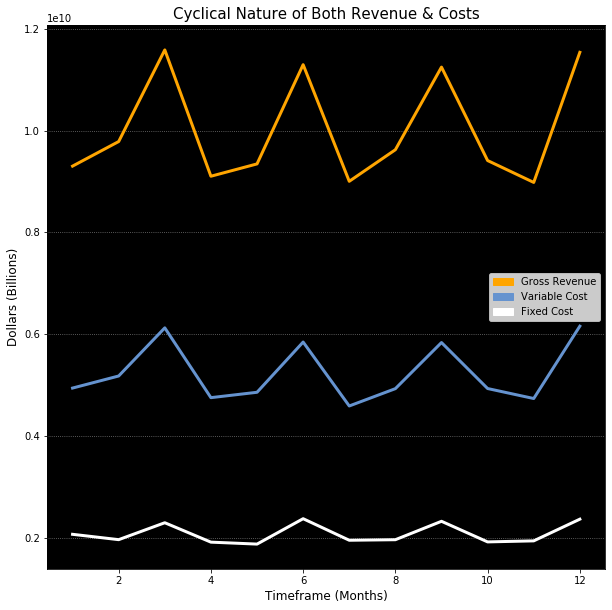

In [13]:
#extracting revenue & cost data 
import matplotlib.patches as mpatches
def extract(col, factor='Month'):
    return pd.DataFrame(df.groupby(factor).sum()[col]).T.reset_index().drop(columns='index')

fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor('black')
ax.plot(extract('Fixed cost').columns, extract('Fixed cost').iloc[0], color="white", linewidth=3)
ax.plot(extract('Variable cost').columns, extract('Variable cost').iloc[0], color="#m", linewidth=3)
ax.plot(extract('Gross revenue').columns, extract('Gross revenue').iloc[0], color="orange", linewidth=3)
ax.grid(color='grey', axis='y', linestyle="dotted")
orange_patch = mpatches.Patch(color='orange', label='Gross Revenue')
blue_patch = mpatches.Patch(color='#6593cf', label='Variable Cost')
white_patch = mpatches.Patch(color='white', label='Fixed Cost')
ax.set_xlabel('Timeframe (Months)', fontsize=12)
ax.set_ylabel('Dollars (Billions)', fontsize=12)
ax.set_title('Cyclical Nature of Both Revenue & Costs', fontsize=15)

ax.legend(handles=[orange_patch, blue_patch, white_patch])

<strong>Notice how fixed cost spikes with gross revenue<strong>

# Analysis of Location Data 
- From the weights we have extracted from earlier models, it was determined that location has very little effect on the outputs of the model. 
- However, after visualizing per capita profit and distribution of stores across states, it is evident that there are opportunities in further investment in Colorado. The retail locations within the state have the second highest per capita profit while representing the second fewest number of stores by state.

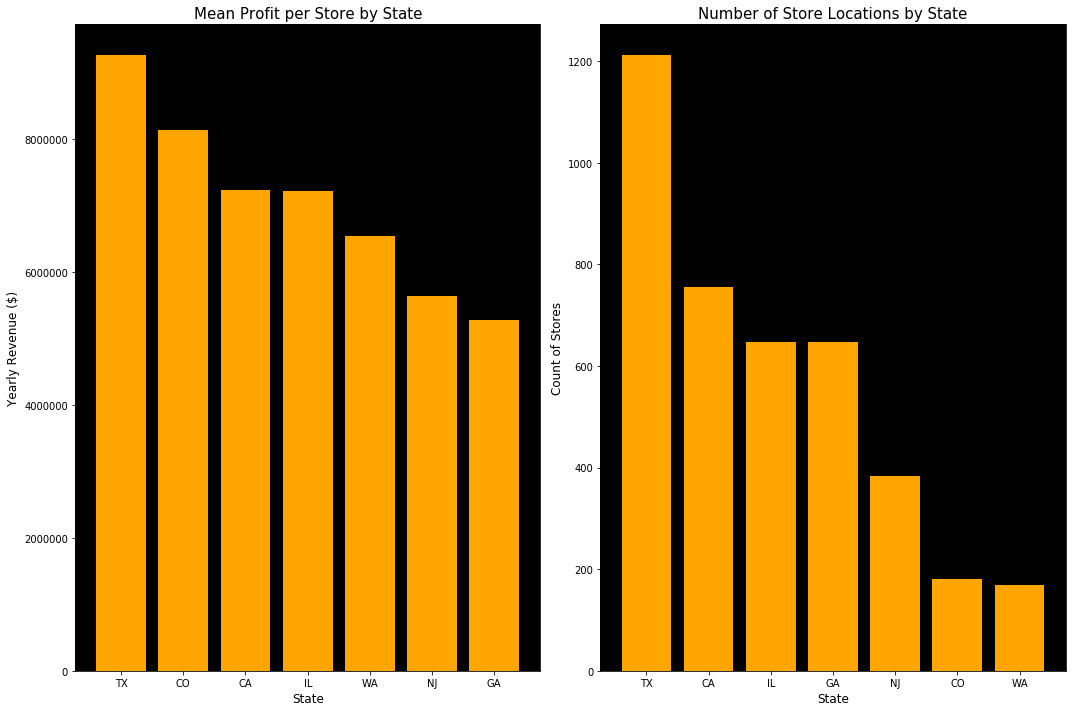

In [14]:
#business intelligence breakdown
net_profit = ((df.groupby('State').mean()['profit_margin'] * 0.01 ) * df.groupby('State').mean()['Gross revenue']).sort_values(ascending=False)
num_stores = df.groupby('State').count()['Location number'].sort_values(ascending=False)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax[0].bar(net_profit.index, net_profit, color='orange')
ax[0].set_facecolor('black')
ax[0].set_xlabel('State', fontsize=12)
ax[0].set_ylabel('Yearly Revenue ($)', fontsize=12)
ax[0].set_title('Mean Profit per Store by State', fontsize=15)
ax[1].bar(num_stores.index, num_stores, color='orange')
ax[1].set_facecolor('black')
ax[1].set_xlabel('State', fontsize=12)
ax[1].set_ylabel('Count of Stores', fontsize=12)
ax[1].set_title('Number of Store Locations by State', fontsize=15)
fig.tight_layout()